In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install umap-learn[plot]
!pip install gensim

In [ ]:
from statistics import linear_regression
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer


from sklearn.pipeline import Pipeline
import nltk
import umap
from nltk.help import upenn_tagset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, average_precision_score
import pandas as pd
import numpy as np
import time
import os
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import wordnet,subjectivity,stopwords
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import re
import string
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import torch # torch provides basic functions, from setting a random seed (for reproducability) to creating tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import Adam # optim contains many optimizers. Here, we're using SGD, stochastic gradient descent, specifically Adam.
from torch.utils.data import TensorDataset, DataLoader



import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

nltk.download("subjectivity")
nltk.download('tagsets_json')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

cpu


[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_ta

True

In [ ]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
stop_words = set(stopwords.words("english"))
def tokenize_samples(samples):
    tokenized_samples = []
    for sample in samples:
        tokens = []
        # Split text into sentences
        sentences = sent_tokenize(sample)
        for sent in sentences:
            # Tokenize each sentence into words
            words = word_tokenize(sent)
            for word in words:
                # Filter out stopwords and unwanted tokens
                if '\n' in word or "\t" in word or "--" in word or "*" in word or word.lower() in stop_words:
                    continue
                if word.strip():
                    # Process the token and add to list
                    tokens.append(word.replace('"', "'").strip().lower())
        tokenized_samples.append(tokens)

    return tokenized_samples

## Preprocessing
Minimal preprocessing with tagging and lemmatizing and transforming the data into a convenient form.

In [ ]:
print(subjectivity.categories())
# print(subjectivity.sents(categories="subj"))
subjective_sentences = subjectivity.sents(categories="subj")
objective_sentences = subjectivity.sents(categories="obj")

data_with_labels = []
assert(len(subjective_sentences) == len(objective_sentences))
for i in range(len(subjective_sentences)):
    obj_sentence = objective_sentences[i]
    subj_sentence = subjective_sentences[i]
    data_with_labels.append({"label":"obj","sentence":obj_sentence})
    data_with_labels.append({"label":"subj","sentence":subj_sentence})

# print(upenn_tagset()) -> Μέρη του λόγου σε προτάσεις και σε τι κλήση κλπ βρίσκονται
lemmatizer = WordNetLemmatizer()
tagger = PerceptronTagger()
docs = []
labels = []
for doc in tqdm(data_with_labels):
    sentence = " ".join(doc["sentence"])
    label = doc["label"]
    document = re.sub(r'\W', ' ', str(sentence))

    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    document = re.sub(r'\s+', ' ', document, flags=re.I)

    document = document.lower()

    document = document.split()

    doc_pos = [x[1] for x in tagger.tag(document)]

    document = \
        [lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag)) \
             if nltk_pos_tagger(pos_tag) != None else lemmatizer.lemmatize(token) \
         for token, pos_tag in zip(document, doc_pos)]

    document = ' '.join(document)

    docs.append(document)
    value_of_label = 0 if label == "subj" else 1
    labels.append(value_of_label)
    # labels.append(label)
# print(docs)
print(len(subjective_sentences),len(objective_sentences))

['obj', 'subj']


100%|██████████| 10000/10000 [00:36<00:00, 274.79it/s]

5000 5000


## Data Splitting
Data is split into training(56%), validation(14%) and test data(30%).
We then tokenize the samples.

In [ ]:
X_train_val,X_test,y_train_val,y_test = train_test_split(docs, labels, test_size=0.3, random_state=1924)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=1924)

print('Train samples: {}'.format(len(X_train)))
print('Val samples: {}'.format(len(X_val)))
print('Test samples: {}'.format(len(X_test)))

X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

Train samples: 5600
Val samples: 1400
Test samples: 3000


## Features
A Simple TF-IDF feature set is used as previously done.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

# we use SVD to not change our MLP tf_idf model
svd = TruncatedSVD(n_components=300, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)

print(X_train_svd.shape)
print(X_val_svd.shape)
print(X_test_svd.shape)

(5600, 5000)
(1400, 5000)
(3000, 5000)
(5600, 300)
(1400, 300)
(3000, 300)


In [ ]:
class MLP_tf_idf(nn.Module):

    def __init__(self,first_layer_size,second_layer_size,dropout_ratio):
      # You can pass more arguments in __init__ like the shapes of the hidden layers or dropout probability. I have not done that here since this serves
                        # as an elementary example. Then, everytime you call the model class you have to set a value to these hyperparameters. This can help a lot when you're
                        # trying to tune your hyperparameters. Please check the pytorch documentation for more.
        super(MLP_tf_idf, self).__init__()
        # an affine operation: y = Wx + b
        self.dense1 = nn.Linear(300, first_layer_size)  # 500 from the dimensions of the tensor inputs. In this case, each item will be a vector of 500 SVD values
        self.dense2 = nn.Linear(first_layer_size,second_layer_size)
        self.dense3 = nn.Linear(second_layer_size, 2) # 20 classes so we need a final layer of shape (20,)
        self.dropout = nn.Dropout(dropout_ratio)
        # If you want to do different dropout probabilities at different layers you can do self.dropout1 = nn.Dropout(0.2), self.dropout2 = nn.Dropout(0.3) etc.

    def forward(self, input):
        # Dense layer 1. Takes the vector of shape 500 and maps it to 512 nodes.
        # Input shape: (batch_size, 500)
        d1 = F.relu(self.dense1(input)) # (batch_size, 512)
        # Apply 50% dropout
        drop1 = self.dropout(d1) # (batch_size, 512)
        # Dense layer 2. Takes the 512 nodes and connects them to 256 nodes
        d2 = F.relu(self.dense2(drop1)) # (batch_size, 256)
        # Apply 50% dropout
        drop2 = self.dropout(d2) # (batch_size, 256)
        # Connect the layer of 256 nodes to the final layer of 20 nodes (one per news category)
        #output = F.softmax(self.dense3(drop2), dim = 1) # (batch_size, 20)
        logits = self.dense3(drop2) # (batch_size, 20)
        #return output
        return logits # Careful! Pytorch' CrossEntropyLoss expects un-softmaxed logits.



mlp_classifier = MLP_tf_idf(256,256,0.5)
print(mlp_classifier)

# Count the total number of parameters
total_params = sum(p.numel() for p in mlp_classifier.parameters())
print(f"MLP TF-IDF Total number of parameters: {total_params}")

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in mlp_classifier.parameters() if p.requires_grad)
print(f"MLP TF-IDF Number of trainable parameters: {trainable_params}")

X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print("Batch size is: ",batch_size)

def train_mlp_with_params(first_layer_size,second_layer_size,dropout_prob):
    global train_loader,val_loader,test_loader
    print(f"Running MLP TF-IDF training {first_layer_size},{second_layer_size},{dropout_prob}")
    model_mlp_tf_idf = MLP_tf_idf(first_layer_size,second_layer_size,dropout_prob) # Custom layer sizes
    model_mlp_tf_idf.to(device)
    optimizer = Adam(model_mlp_tf_idf.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}
    epochs = 150

    best_val_loss = float("inf") # Initialize to a high value to track the lowest validation loss
    best_model_path = None  # To keep track of the previous best model file


    for epoch in range(epochs):
        model_mlp_tf_idf.train()  # Set the model to training mode
        running_loss = 0.0  # Track the loss for the epoch
        train_outputs = [] # the list which contains the outputs of a batch
        train_labels = [] # the list which contains the labels of a batch


        for batch in train_loader:

            features, labels = batch
            features = features.to(device) # Move features to device
            labels = labels.to(device) # Move labels to device

            optimizer.zero_grad()  # Zero the gradients

        # Forward pass: Computes the model output
            outputs = model_mlp_tf_idf(features)

        # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels)  # labels should be class indices, not one-hot
            loss.backward()  # Backward pass

            optimizer.step()  # Optimize (Update the model parameters)

        # Accumulate the loss
            running_loss += loss.item()

        # the outputs from forward pass
            train_outputs.append(outputs)
            train_labels.append(labels)

        #----------------------------------------------------------------------------------------------------------------

    # Concatenate all outputs and labels
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

    # (1) Get label indices
    ####################################################
    #train_classes = torch.argmax(train_labels, dim = 1)
    ####################################################
        train_classes = train_labels

    # (2) Get predicted class indices (we want ro transform the vector to one-hot
    #     (we put one in the index of max element and zeros to others))
        train_predicted_classes = torch.argmax(train_outputs, dim=1)

    # Print average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        # print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    #mexri 0.003 kati

        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
        train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1_score'].append(train_f1_score)

    ############################################################################

    # Validation phase
    # Set the model to evaluation mode
        model_mlp_tf_idf.eval()
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

    # We want to not update the gradients when it is updating the weights
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model_mlp_tf_idf(features)
            # We compute the validation loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)
        true_classes = all_labels

        # Get predicted class indices
        predicted_classes = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
        val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

        # Append to history
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_score'].append(val_f1)

        # Print validation metrics
        # print(f"Validation Loss: {val_loss}")
        # print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        # Save checkpoint at the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

            # Delete the previous best model if it exists
            if best_model_path is not None:
                os.remove(best_model_path)

            # Save the new best model
            torch.save(model_mlp_tf_idf.state_dict(), new_model_path)
            best_model_path = new_model_path  # Update the best model path
            #print(f"Checkpoint saved at epoch {epoch+1} with F1: {val_f1:.4f}")
    return model_mlp_tf_idf,history,best_model_path

hyper_parameters = []
hyper_parameters.append((512,128,0.4))
hyper_parameters.append((256,64,0.3))
hyper_parameters.append((128,64,0.2))
results = []
for var_element in hyper_parameters:
    model_mlp_tf_idf,history,best_model_path = train_mlp_with_params(var_element[0], var_element[1], var_element[2])
    results.append((model_mlp_tf_idf,history,best_model_path))


MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
MLP TF-IDF Total number of parameters: 143362
MLP TF-IDF Number of trainable parameters: 143362
Batch size is:  256
Running MLP TF-IDF training 512,128,0.4
Running MLP TF-IDF training 256,64,0.3
Running MLP TF-IDF training 128,64,0.2


In [ ]:
def plot_training_history(history):
    # Plotting loss
    plt.figure()
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting accuracy
    plt.figure()
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting F1 score
    plt.figure()
    plt.plot(history['train_f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
def plot_training_histories(histories,hyper_parameters):
    # global hyper_parameters
    # Plotting loss
    colors = [("lightgreen","green"),("lightblue","blue"),("pink","red")]
    plt.figure()
    for (index,history) in enumerate(histories):
      plt.plot(history['train_loss'], label=f'Training Loss {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][0])
      plt.plot(history['val_loss'], label=f'Validation Loss {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][1])

    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=(0.42,0.2))
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):
        plt.plot(history['train_accuracy'], label=f'Training Accuracy {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][0])
        plt.plot(history['val_accuracy'], label=f'Validation Accuracy {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][1])
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):
        plt.plot(history['train_f1_score'], label=f'Training Accuracy {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][0])
        plt.plot(history['val_f1_score'], label=f'Validation Accuracy {hyper_parameters[index][0],hyper_parameters[index][1],hyper_parameters[index][2]}',color=colors[index][1])
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

## Baseline Models (Logistic Regression, Majority Classifier, MLP)

Logistic Regression Training Accuracy: 87.70%
Logistic Regression Classification report for Training Data
              precision    recall  f1-score   support

        subj       0.88      0.86      0.87      2742
         obj       0.87      0.89      0.88      2858

    accuracy                           0.88      5600
   macro avg       0.88      0.88      0.88      5600
weighted avg       0.88      0.88      0.88      5600

Logistic Regression Validation Accuracy: 86.21%
Logistic Regression Classification report for Validation Data
              precision    recall  f1-score   support

        subj       0.89      0.82      0.86       708
         obj       0.83      0.90      0.87       692

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.86      0.86      0.86      1400

Logistic Regression Test Accuracy:86.40%
Logistic Regression Classification report for Test Data
              precision    recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Results in Training Data for MLP with TFIDF Features, trained for 150 epochs
              precision    recall  f1-score   support

        subj       1.00      1.00      1.00      2742
         obj       1.00      1.00      1.00      2858

    accuracy                           1.00      5600
   macro avg       1.00      1.00      1.00      5600
weighted avg       1.00      1.00      1.00      5600

MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs
              pre

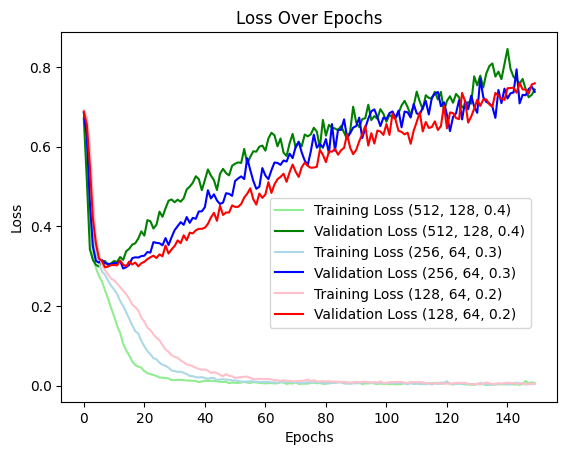

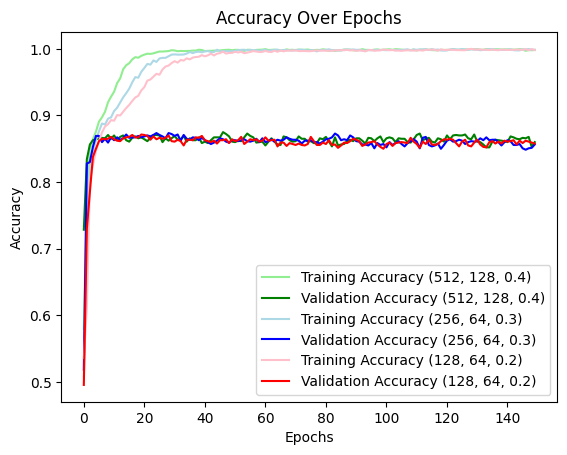

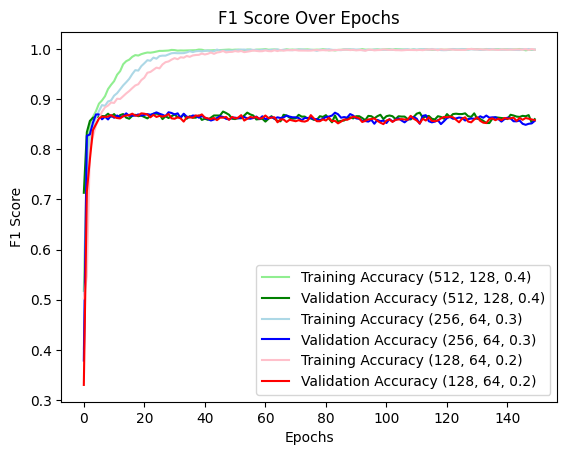

In [ ]:
def check_simple_models(train_X,train_Y,validation_X,validation_Y,test_X,test_Y):
    global results
    clf = LogisticRegression(solver="sag", random_state = 42)
    clf.fit(train_X, train_Y)

    predictions = clf.predict(train_X)
    print(f'Logistic Regression Training Accuracy: {accuracy_score(train_Y, predictions)*100:.2f}%')
    print("Logistic Regression Classification report for Training Data")
    print(classification_report(train_Y, predictions, target_names=["subj","obj"]))

    predictions = clf.predict(validation_X)
    print(f'Logistic Regression Validation Accuracy: {accuracy_score(validation_Y, predictions)*100:.2f}%')
    print("Logistic Regression Classification report for Validation Data")
    print(classification_report(validation_Y, predictions, target_names=["subj","obj"]))


    predictions = clf.predict(test_X)
    print(f'Logistic Regression Test Accuracy:{accuracy_score(test_Y, predictions)*100:.2f}%')
    print("Logistic Regression Classification report for Test Data")
    print(classification_report(test_Y, predictions, target_names=["subj","obj"]))


    baseline = DummyClassifier(strategy='most_frequent')
    baseline.fit(train_X,train_Y)

    predictions = baseline.predict(train_X)
    score = accuracy_score(train_Y, predictions)
    print("Majority Classifier Train accuracy: {:.2f}%".format(score*100))
    print(classification_report(train_Y, predictions, target_names=["subj","obj"]))

    predictions_val = baseline.predict(validation_X)
    score = accuracy_score(validation_Y,predictions_val)
    print("Majority Classifier Validation accuracy: {:.2f}%".format(score*100))
    print(classification_report(validation_Y, predictions_val, target_names=["subj","obj"]))


    predictions_test = baseline.predict(test_X)
    score = accuracy_score(test_Y, predictions_test)
    print("Majority Classifier Test accuracy: {:.2f}% \n".format(score*100))

    print("Majority Classifier Report for Test Data")
    print(classification_report(test_Y, predictions_test, target_names=["subj","obj"]))

    print("MLP with TF-IDF Features")
    for model_mlp_tf_idf,history,best_model_path in results:
        model_mlp_tf_idf.eval()
        model_mlp_tf_idf.to("cpu")
        # For MLP, a complex model it memorises the training data
        pred_training = model_mlp_tf_idf(X_train_tensor)
        y_pred_training = torch.argmax(pred_training,dim=1)
        print(model_mlp_tf_idf)
        print(f"Results in Training Data for MLP with TFIDF Features, trained for 150 epochs")
        print(classification_report(y_train, y_pred_training, target_names=["subj","obj"]))

        pred_val = model_mlp_tf_idf(X_val_tensor)
        y_pred_val = torch.argmax(pred_val, dim=1)
        print(model_mlp_tf_idf)
        print(f"Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs")
        print(classification_report(y_val, y_pred_val, target_names=["subj","obj"]))

        print(f'MLP TF-IDF Validation Accuracy: {accuracy_score(y_val, y_pred_val)*100:.2f}%')

        predictions_test = model_mlp_tf_idf(X_test_tensor)
        y_pred_test = torch.argmax(predictions_test, dim=1)
        print(f'MLP TF-IDF Test Accuracy:{accuracy_score(y_test, y_pred_test)*100:.2f}%')
        print(classification_report(y_test, y_pred_test, target_names=["subj","obj"]))
      # For MLP Only
    histories = list(map(lambda x: x[1],results))
    plot_training_histories(histories,hyper_parameters)
check_simple_models(X_train_svd,y_train,X_val_svd,y_val,X_test_svd,y_test)

## Producing WordEmbeddings

In [ ]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [ ]:
from collections import Counter


MAX_SEQUENCE_LENGTH = 100
MAX_WORDS = 100000

# Build vocabulary from tokens in X_train_tokenized
all_tokens = [token for sentence in X_train_tokenized for token in sentence]
token_counts = Counter(all_tokens)

# Initialize vocabulary with special tokens <pad> and <unk>
vocab = {"<pad>": 0, "<unk>": 1}

# Sort tokens by frequency in descending order and add to vocab starting from 2
for i, (token, _) in enumerate(token_counts.most_common(MAX_WORDS), start=2):
    vocab[token] = i

# Encode and pad each sentence
def encode_sentence(sentence, vocab, max_length=100):
    # Map each token to its vocabulary ID or <unk> if not in vocab
    encoded = [vocab.get(token, vocab["<unk>"]) for token in sentence]
    # Pad or truncate to max_length
    return encoded[:max_length] + [vocab["<pad>"]] * max(0, max_length - len(encoded))

# Apply encoding and padding to each sentence in X_train_tokenized
train_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_train_tokenized]
val_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_val_tokenized]
test_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_test_tokenized]

In [ ]:
EMBEDDING_DIM = 300
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 300
embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))

count = 0
for word, i in vocab.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_matrix[i] = word2vec[word]
        count+=1
    except:
        pass

#Return the number of the elements that are non-zero.
print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

print(embedding_matrix.shape)

11179
11179
(100002, 300)


In [ ]:
del word2vec
del vocab

In [ ]:
# Assuming train_data, y_train, val_data, y_val, test_data, y_test are lists of sentence encodings and labels

# Create datasets for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(train_data, dtype = torch.long), torch.tensor(y_train, dtype = torch.long))
val_dataset = TensorDataset(torch.tensor(val_data, dtype = torch.long), torch.tensor(y_val, dtype = torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype = torch.long), torch.tensor(y_test, dtype = torch.long))

BATCH_SIZE = 256
# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
EPOCHS=30
MAX_WORDS = 100000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 200

class BiGRU(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dim, gru_hidden_dim, gru_stacks, matrix_embeddings = None):
        super(BiGRU, self).__init__()

        # dimensions
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.gru_hidden_dim = gru_hidden_dim
        self.gru_stacks = gru_stacks

        # Embedding layer
        if matrix_embeddings is not None:
            self.embeddings = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embeddings.requires_grad = False # Don't change the embedding matrix
        else:
            self.embeddings = nn.Embedding(num_embeddings = MAX_WORDS + 2, embedding_dim = EMBEDDING_DIM, padding_idx=0)
            self.embeddings.requires_grad = True # Learn the embedding matrix

        # GRU layer
        self.bigru = nn.GRU(input_size = self.input_dim,
                            hidden_size = self.gru_hidden_dim,
                            num_layers = self.gru_stacks,
                            bidirectional = True,
                            batch_first = True)

        # Dropout layer
        self.dropout = nn.Dropout(0.33)

        # Dense layer
        self.dense1 = nn.Linear(self.gru_hidden_dim * 2, self.hidden_dim) # gru_hidden_dim*2 because we will concatenate the left-to-right and right-to-left final states

        # Classification layer
        self.dense2 = nn.Linear(self.hidden_dim, self.n_classes)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)
        # Embedding layer
        x = self.embeddings(input.long()) # (batch_size, sequence_length, embedding_dim)
        #
        gru_out, final_state = self.bigru(x) # gru_out (batch_size, sequence_length, 2*gru_hidden_dim)
                                             # final_state (2, batch_size, gru_hidden_dim)

        left_to_right_final_state = final_state[-2, :, :] # Final hidden state of the GRU if you go from left to right (batch_size, gru_hidden_dim)
        right_to_left_final_state = final_state[-1, :, :] # Final hidden state of the GRU if you go from right to left (batch_size, gru_hidden_dim)

        # You can combine the final states in any way you see fit. Here I concatenate them
        final_state_concat = torch.cat((left_to_right_final_state, right_to_left_final_state), dim = 1) # (batch_size, gru_hidden_dim*2)

        # Dense layer 1
        x = F.relu(self.dense1(final_state_concat)) # (batch_size, hidden_dim)
        # Dropout
        x = self.dropout(x) # (batch_size, hidden_dim)
        # Output layer
        logits = self.dense2(x) # (batch_size, n_classes)

        return logits



## Training the GRU RNN

In [ ]:
DENSE = 16
GRU_SIZE = 32
GRU_STACKS = 1
rnn_params = [(16,32,1),(16,32,2),(8,16,1)]

rnn_models = []
for hid_dim,gru_hid_dim,gru_stack in rnn_params:
    bigru = BiGRU(input_dim=EMBEDDING_DIM,
              n_classes=len(["subj","obj"]),
              matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float32),
              hidden_dim=hid_dim,
              gru_hidden_dim=gru_hid_dim,
              gru_stacks = gru_stack)
    rnn_models.append(bigru)



In [ ]:
rnn_results = []
for model in rnn_models:
    torch.manual_seed(1)
    model.to(device)

    optimizer = Adam(model.parameters(), lr = 0.01) ## here we're creating an optimizer to train the neural network.
                                                ## NOTE: There are a bunch of different ways to optimize a neural network.
                                                ## In this example, we'll use Adam. .

    criterion = nn.CrossEntropyLoss()

    epochs=10
    #best_f1 = 0
    best_val_loss = float("inf") # Initialize to a high value to track the lowest validation loss
    best_model_path = None  # To keep track of the previous best model file

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}

    start_training_time = time.time()

    ## this is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        train_outputs = []
        train_labels = []

        ## this internal loop is where the optimizer sees all of the training data and where we
        ## calculate the total_loss for all of the training data.
        for batch in train_loader:

            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(features)

            # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels)  # labels should be class indices, not one-hot
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()

            train_outputs.append(outputs)
            train_labels.append(labels)



        # Concatenate all outputs and labels
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

        # Get label indices
        #train_classes = torch.argmax(train_labels, dim = 1)
        train_classes = train_labels

        # Get predicted class indices
        train_predicted_classes = torch.argmax(train_outputs, dim=1)

        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
        train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1_score'].append(train_f1_score)


        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}")


        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)  # Validation loss
                val_running_loss += loss.item()

                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)
        true_classes = all_labels

        # Get predicted class indices
        predicted_classes = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
        val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

        # Append to history
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_score'].append(val_f1)

        # Print validation metrics
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        # Save checkpoint at the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

            # Delete the previous best model if it exists
            if best_model_path is not None:
                os.remove(best_model_path)

            # Save the new best model
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path  # Update the best model path
            #print(f"Checkpoint saved at epoch {epoch+1} with F1: {val_f1:.4f}")

    print("Training complete!")
    rnn_results.append((model,history,best_model_path))
    end_training_time = time.time()

Epoch 1/10, Training Loss: 0.5022319975224409
Validation Loss: 0.32404691974322003
Validation Accuracy: 0.8636, F1 Score: 0.8630
Epoch 2/10, Training Loss: 0.3046457442370328
Validation Loss: 0.2608775123953819
Validation Accuracy: 0.8921, F1 Score: 0.8921
Epoch 3/10, Training Loss: 0.2447297288612886
Validation Loss: 0.25624504685401917
Validation Accuracy: 0.8957, F1 Score: 0.8957
Epoch 4/10, Training Loss: 0.2017034183848988
Validation Loss: 0.25804225852092105
Validation Accuracy: 0.8943, F1 Score: 0.8943
Epoch 5/10, Training Loss: 0.16357266665859657
Validation Loss: 0.28966815769672394
Validation Accuracy: 0.8871, F1 Score: 0.8870
Epoch 6/10, Training Loss: 0.12621707977219063
Validation Loss: 0.28397953510284424
Validation Accuracy: 0.8943, F1 Score: 0.8943
Epoch 7/10, Training Loss: 0.093265505338257
Validation Loss: 0.31701640288035077
Validation Accuracy: 0.8993, F1 Score: 0.8993
Epoch 8/10, Training Loss: 0.06298153178597038
Validation Loss: 0.4071497619152069
Validation Acc

## RNN with MLP head Assessment

In [ ]:
for pos,(model,history,best_model_path) in enumerate(rnn_results):
    model.load_state_dict(torch.load(best_model_path, weights_only = True))
    params = rnn_params[pos]
    print("BiGRU model with params: ",params)
    # Set the model to evaluation mode
    model.eval()
    model.to("cpu")

    pred_val = model(torch.tensor(val_data, dtype = torch.long))
    y_pred_val = torch.argmax(pred_val, dim=1)
    print(classification_report(y_val, y_pred_val, target_names=["subj","obj"]))
    print(f'Validation Accuracy: {accuracy_score(y_val, y_pred_val)*100:.2f}%')

    predictions_test = model(torch.tensor(test_data, dtype = torch.long))
    y_pred_test = torch.argmax(predictions_test, dim=1)
    print(classification_report(y_test, y_pred_test, target_names=["subj","obj"]))
    print(f'Test Accuracy:{accuracy_score(y_test, y_pred_test)*100:.2f}%')

histories = list(map(lambda x: x[1],rnn_results))
plot_training_histories(histories,rnn_params)

FileNotFoundError: [Errno 2] No such file or directory: 'mlp_best_model_epoch_3.pth'